In [2]:
import pandas as pd
from sklearn.metrics import f1_score, classification_report, confusion_matrix, precision_recall_curve, PrecisionRecallDisplay
import numpy as np
from pathlib import Path
import gensim
import torch
import gensim.downloader as gloader
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import time
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

c:\Users\marco\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [ ]:
print(f"Current work directory: {Path.cwd()}")
dataset_folder = Path.cwd().joinpath("dependency_treebank")

### Splits

The corpus contains 200 documents.

   * **Train**: Documents 1-100
   * **Validation**: Documents 101-150
   * **Test**: Documents 151-199

In [4]:
data = []

for file_path in dataset_folder.glob('*.dp'):            
    with file_path.open(mode='r', encoding='utf-8') as text:
        lines = text.read().split('\n')
        words = []
        tags = []
        for line in lines:
            parts = line.split()
            if len(parts) == 3:
                word, tag, _ = parts
                words.append(word)
                tags.append(tag)
        data.append([(words, tags)])


df = pd.DataFrame(data, columns=['doc'])

In [5]:
df.head(10)

,doc
0,"([Pierre, Vinken, ,, 61, years, old, ,, will, ..."
1,"([Rudolph, Agnew, ,, 55, years, old, and, form..."
2,"([A, form, of, asbestos, once, used, to, make,..."
3,"([Yields, on, money-market, mutual, funds, con..."
4,"([J.P., Bolduc, ,, vice, chairman, of, W.R., G..."
5,"([Pacific, First, Financial, Corp., said, shar..."
6,"([McDermott, International, Inc., said, its, B..."
7,"([The, federal, government, suspended, sales, ..."
8,"([Clark, J., Vitulli, was, named, senior, vice..."
9,"([When, it, 's, time, for, their, biannual, po..."


In [6]:
from collections import OrderedDict

# Build vocabulary
def build_vocabulary(df: pd.DataFrame):
    word_to_idx = OrderedDict()
    tag_to_idx = OrderedDict()
    
    word_idx = 0
    tag_idx = 0

    for doc in df.doc.values:
        tokens = doc[0]
        tags = doc[1]
        for token in tokens:
            if token not in word_to_idx:
                word_to_idx[token] = word_idx
                word_idx += 1
        for tag in tags:
            if tag not in tag_to_idx:
                tag_to_idx[tag] = tag_idx
                tag_idx +=1

    # Add [UNK] token for OOV words
    word_to_idx["[UNK]"] = word_idx

    return word_to_idx, tag_to_idx

In [7]:
# Split the data into training, validation, and test sets
train_split = df[0:100]
val_split = df[100:150].reset_index(drop=True)
test_split = df[150:199].reset_index(drop=True)

# Display the shapes of the sets
print("Training set shape:", len(train_split))
print("Validation set shape:", len(val_split))
print("Test set shape:", len(test_split))

Training set shape: 100
Validation set shape: 50
Test set shape: 49


In [8]:
# Build vocabulary and tags, word-to-index format
global_vocab, global_tags = build_vocabulary(df)
train_vocab, train_tags = build_vocabulary(train_split)

print(f'Global vocabulary -> Tags size: {len(global_tags)}')
print(f'Global vocabulary -> Index vocabulary size: {len(global_vocab)}')

print(f'Training vocabulary-> Tags size: {len(train_tags)}')
print(f'Training vocabulary -> Index vocabulary size: {len(train_vocab)}')

Global vocabulary -> Tags size: 45
Global vocabulary -> Index vocabulary size: 11969
Training vocabulary-> Tags size: 45
Training vocabulary -> Index vocabulary size: 8010


In [9]:
excluded_tags = OrderedDict(filter(lambda i: i[0] in [',', '.', '``', '\'\'', ':', '$', '-LRB-', '-RRB-', '#'], global_tags.items()))
excluded_tags

OrderedDict([(',', 1),
             ('.', 10),
             ('``', 26),
             ("''", 28),
             (':', 30),
             ('$', 33),
             ('-LRB-', 36),
             ('-RRB-', 37),
             ('#', 44)])

To train a neural POS tagger, you first need to encode text into numerical format.

Words are embedded using **GloVe embeddings**.

In [10]:
emb_model = gloader.load("glove-wiki-gigaword-100")

In [11]:
def get_OOV_terms(embedding_model: gensim.models.keyedvectors.KeyedVectors,
                  word_to_idx):
    embedding_vocabulary = set(embedding_model.key_to_index.keys())
    oov = set(word_to_idx.keys()).difference(embedding_vocabulary)
    return list(oov)

oov_terms = get_OOV_terms(emb_model, global_vocab)
oov_percentage = float(len(oov_terms)) * 100 / len(set(global_vocab.keys()))
print(f"Total OOV terms: {len(oov_terms)} ({oov_percentage:.2f}%)")

Total OOV terms: 3746 (31.30%)


In [12]:
def embed_word(word, train_vocab, embedding_model, embedding_dimension):
    try:
        return torch.squeeze(torch.tensor(embedding_model[word]))
    except (KeyError):
        # Except catch embeddings not present in Glove
        if word in train_vocab.keys() and word != "[UNK]":
            # OOV embedding for training set, in the training set we should have an embedding for oov words
            return torch.tensor(np.random.uniform(low=-0.05, high=0.05, size=embedding_dimension), dtype=torch.float32)
        else:
            if word == "[UNK]":
                return torch.zeros(embedding_dimension)

def build_embedding_matrix(global_vocab, train_vocab, embedding_model, embedding_dimension):
    '''
        I am also building the final vocabulary with the words in the dataset minus the OOV in test/validation
        The OOV of the training are instead kept with a specific embedding
    '''
    t = []
    vocab = OrderedDict()
    idx = 0

    for w in global_vocab:
        e = embed_word(w, train_vocab, embedding_model, embedding_dimension)
        if e is not None:
            vocab[w] = idx
            idx +=1
            t.append(e)
    return torch.stack(t), vocab

In [13]:
# Define embedding matrix
train_emb_matrix, final_vocab = build_embedding_matrix(global_vocab, train_vocab, emb_model, 100)

In [14]:
# Sanity check
torch.all(torch.eq(torch.tensor(emb_model["major"]), train_emb_matrix[final_vocab["major"]])) and torch.all(torch.eq(torch.tensor(emb_model["street"]), train_emb_matrix[final_vocab["street"]]))

tensor(True)

In [15]:
train_emb_matrix.size()

torch.Size([10570, 100])

In [16]:
print(train_emb_matrix[-2])
print(train_emb_matrix[-1])

tensor([-0.3244,  0.8465, -0.5692, -0.3774,  1.0488, -1.0676, -0.3345,  0.0499,
         0.7326,  0.2384,  1.2318,  0.0164,  0.9287, -0.5538,  0.6091, -0.7560,
        -0.3821,  0.8602, -0.1405, -0.0408,  0.2743, -0.0973,  1.1942,  0.1475,
        -0.3266, -0.1162, -0.2708,  0.8588, -0.2909,  0.8833,  0.8562,  0.5291,
        -0.2573,  0.3494,  0.9375,  0.8830, -0.2655, -0.5822,  0.2148, -0.0814,
         0.4326, -0.8328, -0.3314,  0.3622,  0.4342,  0.3715,  0.1212, -0.1988,
         0.0865,  1.1287, -0.0488,  0.5335, -0.3382,  0.8388,  0.1526, -1.4057,
         0.4374, -0.5224,  1.1454,  0.8335, -0.8808,  0.1059,  0.1660,  0.4363,
         0.1849,  0.4419, -0.1773, -0.4333,  0.2662, -0.5618, -0.3018,  0.1875,
         0.6955, -0.5731,  0.0376, -0.2253,  0.6259,  0.9278,  0.4875, -0.7836,
         0.1306, -0.6360, -0.2503,  0.9517, -0.8151,  0.2434,  0.0183,  0.0615,
         0.3020, -0.0655,  0.0866,  0.4295, -0.4348,  0.2115, -0.1157, -0.1821,
        -0.8717, -0.0289,  1.4115,  0.28

# Model definition

Define a neural POS tagger.

### Models

* **Baseline**: Bidirectional LSTM with a Dense layer on top.

* **Model 1**: additional LSTM layer to the Baseline model.
* **Model 2**: additional Dense layer to the Baseline model.

In [17]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [18]:
# Retrieve index from word
def word_to_idx_conv(sentence, to_idx):
    idxs = []
    for w in sentence:
        try:
            idxs.append(to_idx[w[0]])
        except(KeyError):
            # Redirect to [UNK], which is always the last of the vocabulary
            idxs.append(len(to_idx)-1)
    return torch.tensor(idxs, dtype=torch.long)

def tag_to_idx_conv(tags, to_ix):
    idxs = []
    for w in tags:      
        idxs.append(to_ix[w[0]])
    return torch.tensor(idxs, dtype=torch.long)

# Retrieve tag from index
def idx_to_tag_conv(idxs, tag_vocab):
    tags = []
    vocab = list(tag_vocab.items())
    for i in idxs:
        tags.append(vocab[i][0])
    return tags

In [19]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device: %s' % device)

Device: cuda


In [20]:
class Baseline(nn.Module):
    def __init__(self, embedding_dim, vocab_size, tagset_size, freeze=False):
        super().__init__()

        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=vocab_size-1, _freeze=freeze)
        self.lstm1 = nn.LSTM(embedding_dim, embedding_dim, bidirectional=True)
        self.dense1 = nn.Linear(2*embedding_dim, tagset_size)

    def forward(self, sentence):
        
        embedded = self.embedding(sentence)
        lstm_out, _ = self.lstm1(embedded)
        tag_space = self.dense1(lstm_out)
        return tag_space

In [21]:
class Model1(Baseline):
    def __init__(self, embedding_dim, vocab_size, tagset_size, freeze):
        super().__init__(embedding_dim, vocab_size, tagset_size, freeze)
    
        self.lstm1 = nn.LSTM(embedding_dim, embedding_dim, 2, bidirectional=True)

In [22]:
class Model2(Baseline):
    def __init__(self, embedding_dim, vocab_size, tagset_size, freeze):
        super().__init__(embedding_dim, vocab_size, tagset_size, freeze)
        
        self.dense1 = nn.Linear(2*embedding_dim, 2*embedding_dim)
        self.dense2 = nn.Linear(2*embedding_dim, tagset_size)
    def forward(self, sentence):
        
        embedded = self.embedding(sentence)
        lstm1_out, _ = self.lstm1(embedded)
        dense1 = self.dense1(lstm1_out)
        tag_space = self.dense2(dense1)
        return tag_space

In [23]:
def define_models(emb_matrix, tags, device, freeze):
    baseline = Baseline(100, len(emb_matrix), len(tags), freeze).to(device)
    model1 = Model1(100, len(emb_matrix), len(tags), freeze).to(device)
    model2 = Model2(100, len(emb_matrix), len(tags), freeze).to(device)
    models = (baseline, model1, model2)
    for m in models:
        print(f'The {type(m).__name__} model has {count_parameters(m):,} trainable parameters')
    
    return models

In [24]:
baseline, model1, model2 = define_models(train_emb_matrix, global_tags, device, freeze=False)

The Baseline model has 1,227,645 trainable parameters
The Model1 model has 1,469,245 trainable parameters
The Model2 model has 1,267,845 trainable parameters


In [25]:
loss_function = nn.CrossEntropyLoss().to(device)

In [26]:
class CustomDocDataset(Dataset):
    def __init__(self, dataframe, excluded_tags):
        self.data = dataframe.doc
        
        self.tags_freq = {}
        for d in self.data:
            tags = d[1]
            for t in tags:
                try:
                    self.tags_freq[t] +=1
                except (KeyError):
                    self.tags_freq[t] = 1

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        words = self.data[idx][0]
        tags = self.data[idx][1]
        return words, tags
    
    def get_tags_frequencies(self, exclude_punct=False, low_to_high=False):
        if exclude_punct:
            return {k:v for k, v in sorted(self.tags_freq.items(), key=lambda i:i[1], reverse=not low_to_high) if k not in excluded_tags}
        else:
            return {k:v for k, v in sorted(self.tags_freq.items(), key=lambda i:i[1], reverse=not low_to_high)}


train_data = CustomDocDataset(train_split, excluded_tags)
val_data = CustomDocDataset(val_split, excluded_tags)
test_data = CustomDocDataset(test_split, excluded_tags)

train_loader = DataLoader(train_data, batch_size=1, shuffle=True)
val_loader = DataLoader(val_data, batch_size=1, shuffle=False)
test_loader = DataLoader(test_data, batch_size=1, shuffle=True)

In [28]:
train_split.doc

0     ([Pierre, Vinken, ,, 61, years, old, ,, will, ...
1     ([Rudolph, Agnew, ,, 55, years, old, and, form...
2     ([A, form, of, asbestos, once, used, to, make,...
3     ([Yields, on, money-market, mutual, funds, con...
4     ([J.P., Bolduc, ,, vice, chairman, of, W.R., G...
                            ...                        
95    ([The, National, Association, of, Securities, ...
96    ([Program, traders, are, fond, of, predicting,...
97    ([The, House, voted, to, boost, the, federal, ...
98    ([Zenith, Data, Systems, Corp., ,, a, subsidia...
99    ([For, six, years, ,, T., Marshall, Hahn, Jr.,...
Name: doc, Length: 100, dtype: object

# Metrics

* Model evaluated using macro F1-score, computed over **all** tokens.
* **Puncutation and symbol classes are not considered** $\rightarrow$ [What is punctuation?](https://en.wikipedia.org/wiki/English_punctuation)

In [26]:
def categorical_accuracy(preds, gt, tag_pad_idx):
    max_preds = preds.argmax(dim = 1, keepdim = True)
    # some tags are excluded from the metric (punctuation, symbols, ..)
    non_pad_elements = gt[torch.tensor([v not in list(tag_pad_idx.values()) for v in gt])].nonzero()
    correct = max_preds[non_pad_elements].squeeze(1).eq(gt[non_pad_elements])
    return correct.sum() / gt[non_pad_elements].shape[0]

In [27]:
def macro_f1(preds, targets, excluded_tags={}):    
    if len(preds) == len(targets):
        preds = np.asarray(preds)
        targets = np.asarray(targets)
        
        return f1_score(targets, 
                        preds, 
                        average='macro',
                        labels=[label for label in set(targets) if label not in excluded_tags.values()])
    else:
        return -1

In [28]:
concat_tags = []
concat_preds = []
i = 0
for batch_idx, data in enumerate(val_loader):
    inputs, labels = data[0], data[1]
    tags = tag_to_idx_conv(labels, global_tags)
    
    sentence_idxs = word_to_idx_conv(inputs, final_vocab)
    # print(inputs)
    # print(sentence_idxs)
    tag_scores = baseline(sentence_idxs)
    # print(labels)
    # print(tags.size())
    # print(tag_scores.size())


    # max_preds = tag_scores.argmax(dim = 1, keepdim = True)
    # non_pad_elements = tags[torch.tensor([v not in list(excluded_tags.values()) for v in tags])].nonzero()
    # correct = max_preds[non_pad_elements].squeeze(1).eq(tags[non_pad_elements])
    
    concat_tags.extend(tags.tolist())
    concat_preds.extend(tag_scores.argmax(-1).tolist())
    break


In [1]:
def train(net, train_loader, loss_function, word_vocab, tags_vocab, excluded_tags):
    net.train()

    optimizer = torch.optim.Adam(net.parameters())

    losses = []
    accuracy = []
    for batch_idx, data in enumerate(train_loader):
        inputs, labels = data[0], data[1]
        
        optimizer.zero_grad()

        # Retrieve tags and sentence indices
        tags = tag_to_idx_conv(labels, tags_vocab)
        sentence_idxs = word_to_idx_conv(inputs, word_vocab)
        
        tag_scores = net(sentence_idxs)

        # calculate loss
        loss = loss_function(tag_scores, tags)
        
        loss.backward()
        optimizer.step()

        losses.append(loss.cpu()) 
        
        # calculate accuracy
        acc = categorical_accuracy(tag_scores, tags, excluded_tags)
        accuracy.append(acc)

    return losses, accuracy


In [30]:
def validate(net, val_loader, loss_function, word_vocab, tags_vocab, excluded_tags={}):
    net.eval()
    val_losses = []
    val_accuracy = []

    # used for computing macro-f1
    concat_tags = []
    concat_preds = []

    with torch.no_grad():
        for batch_idx, data in enumerate(val_loader):
            inputs, labels = data[0], data[1]
            
            tags = tag_to_idx_conv(labels, tags_vocab)
            sentence_idxs = word_to_idx_conv(inputs, word_vocab)
            
            tag_scores = net(sentence_idxs)

            loss = loss_function(tag_scores, tags)
            val_losses.append(loss.cpu()) 
            
            acc = categorical_accuracy(tag_scores, tags, excluded_tags)
            val_accuracy.append(acc)

            # Exclude tags
            tags = [t for t in tags.tolist() if t not in excluded_tags]
            tag_scores = [t for t in tag_scores.argmax(-1).tolist() if t not in excluded_tags]

            concat_tags.extend(tags)
            concat_preds.extend(tag_scores)

    return val_losses, val_accuracy, concat_preds, concat_tags

In [31]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [32]:
def train_model(model, n_epochs):

    for epoch in range(n_epochs):

        start_time = time.time()
        
        train_loss, train_acc = train(model, train_loader, loss_function, final_vocab, global_tags, excluded_tags)
        valid_loss, valid_acc, pred_tags, true_tags = validate(model, val_loader, loss_function, final_vocab, global_tags, excluded_tags)
        
        end_time = time.time()

        epoch_mins, epoch_secs = epoch_time(start_time, end_time)
        
        print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
        print(f'\tTrain Loss: {torch.mean(torch.tensor(train_loss)):.3f} | Train Acc: {torch.mean(torch.tensor(train_acc))*100:.2f}%')
        print(f'\t Val. Loss: {torch.mean(torch.tensor(valid_loss)):.3f} | Val. Acc: {torch.mean(torch.tensor(valid_acc))*100:.2f}% | Val. Macro-F1: {macro_f1(pred_tags, true_tags, excluded_tags):.2f}')

In [33]:
losses, accuracy, pred_tags, true_tags = validate(baseline, val_loader, loss_function, final_vocab, global_tags, excluded_tags)
print(f"Accuracy: {torch.mean(torch.tensor(accuracy)):.2f}")
print(f"Macro-F1: {macro_f1(pred_tags, true_tags):.2f}")

Accuracy: 0.03
Macro-F1: 0.02


In [34]:
# Initialize weights
def init_weights(model):
    for _, param in model.named_parameters():
        nn.init.normal_(param.data, mean = 0, std = 0.1)
        
baseline.apply(init_weights)
model1.apply(init_weights)
model2.apply(init_weights)

Model2(
  (embedding): Embedding(10570, 100, padding_idx=10569)
  (lstm1): LSTM(100, 100, bidirectional=True)
  (dense1): Linear(in_features=200, out_features=200, bias=True)
  (dense2): Linear(in_features=200, out_features=45, bias=True)
)

In [35]:
# Initializa embedding layer with pretraining embedding matrix
baseline.embedding.weight.data.copy_(train_emb_matrix)
model1.embedding.weight.data.copy_(train_emb_matrix)
model2.embedding.weight.data.copy_(train_emb_matrix)

tensor([[ 0.0121, -0.0130,  0.0431,  ..., -0.0208,  0.0371, -0.0187],
        [ 0.0166, -0.0375, -0.0118,  ...,  0.0312, -0.0143,  0.0210],
        [-0.1077,  0.1105,  0.5981,  ..., -0.8316,  0.4529,  0.0826],
        ...,
        [ 0.1687,  1.1911,  0.1745,  ..., -0.3251,  0.3670, -0.1799],
        [-0.3244,  0.8465, -0.5692,  ..., -0.0289,  1.4115,  0.2803],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]])

In [36]:
EPOCHS = 10

In [37]:
train_model(baseline, EPOCHS)

Epoch: 01 | Epoch Time: 0m 4s
	Train Loss: 2.021 | Train Acc: 50.19%
	 Val. Loss: 1.166 | Val. Acc: 70.28% | Val. Macro-F1: 0.31
Epoch: 02 | Epoch Time: 0m 4s
	Train Loss: 0.746 | Train Acc: 81.89%
	 Val. Loss: 0.641 | Val. Acc: 84.51% | Val. Macro-F1: 0.49
Epoch: 03 | Epoch Time: 0m 4s
	Train Loss: 0.422 | Train Acc: 89.87%
	 Val. Loss: 0.453 | Val. Acc: 88.41% | Val. Macro-F1: 0.56
Epoch: 04 | Epoch Time: 0m 4s
	Train Loss: 0.271 | Train Acc: 93.44%
	 Val. Loss: 0.352 | Val. Acc: 90.44% | Val. Macro-F1: 0.61
Epoch: 05 | Epoch Time: 0m 5s
	Train Loss: 0.188 | Train Acc: 95.32%
	 Val. Loss: 0.301 | Val. Acc: 91.77% | Val. Macro-F1: 0.67
Epoch: 06 | Epoch Time: 0m 4s
	Train Loss: 0.134 | Train Acc: 96.66%
	 Val. Loss: 0.273 | Val. Acc: 92.29% | Val. Macro-F1: 0.70
Epoch: 07 | Epoch Time: 0m 4s
	Train Loss: 0.096 | Train Acc: 97.63%
	 Val. Loss: 0.259 | Val. Acc: 92.57% | Val. Macro-F1: 0.72
Epoch: 08 | Epoch Time: 0m 4s
	Train Loss: 0.069 | Train Acc: 98.36%
	 Val. Loss: 0.243 | Val. Ac

In [38]:
train_model(model1, EPOCHS)

Epoch: 01 | Epoch Time: 0m 6s
	Train Loss: 2.104 | Train Acc: 44.23%
	 Val. Loss: 1.140 | Val. Acc: 70.62% | Val. Macro-F1: 0.31
Epoch: 02 | Epoch Time: 0m 6s
	Train Loss: 0.703 | Train Acc: 82.13%
	 Val. Loss: 0.611 | Val. Acc: 84.38% | Val. Macro-F1: 0.49
Epoch: 03 | Epoch Time: 0m 6s
	Train Loss: 0.370 | Train Acc: 90.73%
	 Val. Loss: 0.416 | Val. Acc: 89.20% | Val. Macro-F1: 0.57
Epoch: 04 | Epoch Time: 0m 6s
	Train Loss: 0.230 | Train Acc: 94.10%
	 Val. Loss: 0.351 | Val. Acc: 90.06% | Val. Macro-F1: 0.63
Epoch: 05 | Epoch Time: 0m 6s
	Train Loss: 0.152 | Train Acc: 95.95%
	 Val. Loss: 0.299 | Val. Acc: 92.12% | Val. Macro-F1: 0.68
Epoch: 06 | Epoch Time: 0m 6s
	Train Loss: 0.105 | Train Acc: 97.36%
	 Val. Loss: 0.268 | Val. Acc: 92.64% | Val. Macro-F1: 0.73
Epoch: 07 | Epoch Time: 0m 6s
	Train Loss: 0.074 | Train Acc: 98.05%
	 Val. Loss: 0.254 | Val. Acc: 93.34% | Val. Macro-F1: 0.73
Epoch: 08 | Epoch Time: 0m 7s
	Train Loss: 0.055 | Train Acc: 98.55%
	 Val. Loss: 0.263 | Val. Ac

In [39]:
train_model(model2, EPOCHS)

Epoch: 01 | Epoch Time: 0m 5s
	Train Loss: 1.545 | Train Acc: 60.42%
	 Val. Loss: 0.756 | Val. Acc: 80.52% | Val. Macro-F1: 0.46
Epoch: 02 | Epoch Time: 0m 5s
	Train Loss: 0.469 | Train Acc: 87.11%
	 Val. Loss: 0.450 | Val. Acc: 87.50% | Val. Macro-F1: 0.57
Epoch: 03 | Epoch Time: 0m 5s
	Train Loss: 0.268 | Train Acc: 92.81%
	 Val. Loss: 0.352 | Val. Acc: 90.23% | Val. Macro-F1: 0.66
Epoch: 04 | Epoch Time: 0m 5s
	Train Loss: 0.172 | Train Acc: 95.21%
	 Val. Loss: 0.294 | Val. Acc: 91.61% | Val. Macro-F1: 0.72
Epoch: 05 | Epoch Time: 0m 5s
	Train Loss: 0.113 | Train Acc: 96.85%
	 Val. Loss: 0.293 | Val. Acc: 91.80% | Val. Macro-F1: 0.74
Epoch: 06 | Epoch Time: 0m 5s
	Train Loss: 0.083 | Train Acc: 97.79%
	 Val. Loss: 0.292 | Val. Acc: 91.93% | Val. Macro-F1: 0.77
Epoch: 07 | Epoch Time: 0m 5s
	Train Loss: 0.062 | Train Acc: 98.27%
	 Val. Loss: 0.299 | Val. Acc: 91.54% | Val. Macro-F1: 0.78
Epoch: 08 | Epoch Time: 0m 6s
	Train Loss: 0.044 | Train Acc: 98.72%
	 Val. Loss: 0.264 | Val. Ac

In [40]:
_, test_acc, pred_tags, true_tags= validate(baseline, test_loader, loss_function, final_vocab, train_tags, excluded_tags)
print(f'Baseline Test. Acc: {torch.mean(torch.tensor(test_acc))*100:.2f}%')
print(f'Baseline Test. F1: {macro_f1(pred_tags, true_tags):.2f}')

Baseline Test. Acc: 94.73%
Baseline Test. F1: 0.88


In [41]:
_, test_acc, pred_tags, true_tags = validate(model1, test_loader, loss_function, final_vocab, train_tags, excluded_tags)
print(f'Model 1 Test. Acc: {torch.mean(torch.tensor(test_acc))*100:.2f}%')
print(f'Model 1 Test. F1: {macro_f1(pred_tags, true_tags):.2f}')

Model 1 Test. Acc: 94.52%
Model 1 Test. F1: 0.86


In [42]:
_, test_acc, pred_tags, true_tags = validate(model2, test_loader, loss_function, final_vocab, train_tags, excluded_tags)
print(f'Model 2 Test. Acc: {torch.mean(torch.tensor(test_acc))*100:.2f}%')
print(f'Model 2 Test. F1: {macro_f1(pred_tags, true_tags):.2f}')

Model 2 Test. Acc: 94.43%
Model 2 Test. F1: 0.87


In [43]:
def tag_sentence(model, sentence, word_vocab, tag_vocab):
    # tags = token_to_idx_conv(actual_tags, tag_vocab)
    sentence_idxs = word_to_idx_conv(sentence, word_vocab)
    tag_scores = model(sentence_idxs)

    pred_tags = tag_scores.argmax(-1)
    
    return idx_to_tag_conv(pred_tags, tag_vocab)

In [44]:
def pretty_comparison():
    sentence, actual_tags = next(iter(test_loader))
    actual_tags = [t[0] for t in actual_tags] #conversion to list

    pred_tags = tag_sentence(baseline, sentence, final_vocab, train_tags)
    pred_tags1 = tag_sentence(model1, sentence, final_vocab, train_tags)
    pred_tags2 = tag_sentence(model2, sentence, final_vocab, train_tags)

    b_acc = torch.mean(torch.tensor([i == j for i, j in zip(pred_tags, actual_tags)]).float())
    m1_acc = torch.mean(torch.tensor([i == j for i, j in zip(pred_tags1, actual_tags)]).float())
    m2_acc = torch.mean(torch.tensor([i == j for i, j in zip(pred_tags2, actual_tags)]).float())

    print(f'Baseline Acc: {b_acc*100:.2f}%')
    print(f'Model1 Acc: {m1_acc*100:.2f}%')
    print(f'Model2 Acc: {m2_acc*100:.2f}%')

    print("Pred. Tag\t\tActual Tag\tCorrect?\tCorrect1?\tCorrect2?\tToken\n")

    for token, pred_tag, pred_tag1, pred_tag2, actual_tag in zip(sentence, pred_tags, pred_tags1, pred_tags2, actual_tags):
        correct = '✔' if pred_tag == actual_tag else '✘'
        correct1 = '✔' if pred_tag1 == actual_tag else '✘'
        correct2 = '✔' if pred_tag2 == actual_tag else '✘'
        preds = pred_tag+','+pred_tag1+','+pred_tag2
        print(f"{preds}\t\t{actual_tag}\t\t{correct}\t\t{correct1}\t\t{correct2}\t\t{token}")

In [118]:
def print_support_graph(tag_freqs, lw_thresh, hgh_thresh):
    # plot
    _, ax = plt.subplots()
    y = [v for v in tag_freqs.values()]
    x = np.arange(1, len(tag_freqs.keys())+1)

    ax.set_yscale('log')
    ax.set_xlabel('N. Tags')
    ax.set_ylabel('Support (log)')

    ax.axhline(y=lw_thresh, color='r', linestyle='--', label='Less frequent threshold')
    ax.axhline(y=hgh_thresh, color='g', linestyle='--', label='Most frequent threshold')

    ax.legend()
    ax.plot(x, y, linewidth=3.0)

    plt.show()

In [226]:
def precs_recall_curve(precisions, recalls):
    _, ax = plt.subplots()

    ax.set_ylabel('Precision')
    ax.set_xlabel('Recall')

    ax.axvline(x=0.8, color='r', linestyle='--')
    # ax.axhline(y=hgh_thresh, color='g', linestyle='--', label='Most frequent threshold')

    ax.legend()
    ax.plot(recalls, precisions, linewidth=2.0)


In [45]:
pretty_comparison()

Baseline Acc: 93.23%
Model1 Acc: 95.22%
Model2 Acc: 93.63%
Pred. Tag		Actual Tag	Correct?	Correct1?	Correct2?	Token

DT,DT,DT		DT		✔		✔		✔		('The',)
NNP,NNP,NNP		NNP		✔		✔		✔		('Bush',)
NN,NN,NN		NN		✔		✔		✔		('administration',)
POS,POS,POS		POS		✔		✔		✔		("'s",)
NN,NN,NN		NN		✔		✔		✔		('nomination',)
IN,IN,IN		IN		✔		✔		✔		('of',)
NNP,NNP,NNP		NNP		✔		✔		✔		('Clarence',)
NNP,NNP,NNP		NNP		✔		✔		✔		('Thomas',)
TO,TO,TO		TO		✔		✔		✔		('to',)
DT,DT,DT		DT		✔		✔		✔		('a',)
NN,NN,NN		NN		✔		✔		✔		('seat',)
IN,IN,IN		IN		✔		✔		✔		('on',)
DT,DT,DT		DT		✔		✔		✔		('the',)
JJ,JJ,JJ		JJ		✔		✔		✔		('federal',)
NNS,NNS,NNS		NNS		✔		✔		✔		('appeals',)
NN,NN,NN		NN		✔		✔		✔		('court',)
RB,RB,RB		RB		✔		✔		✔		('here',)
VBD,VBD,VBD		VBD		✔		✔		✔		('received',)
DT,DT,DT		DT		✔		✔		✔		('a',)
NN,NN,NN		NN		✔		✔		✔		('blow',)
DT,DT,DT		DT		✔		✔		✔		('this',)
NN,NN,NN		NN		✔		✔		✔		('week',)
WRB,WRB,WRB		WRB		✔		✔		✔		('when',)
DT,DT,DT		DT		✔		✔		✔		('the',)
NNP,NNP,NNP		NNP		✔		✔		✔		('American',)
NNP,NN

In [97]:
test_tag_freq = test_data.get_tags_frequencies(exclude_punct=True, low_to_high=True)
print(test_tag_freq)

{'RBS': 3, 'WP$': 4, 'PDT': 4, 'EX': 5, 'RBR': 15, 'WP': 20, 'WRB': 24, 'JJS': 31, 'RP': 33, 'NNPS': 44, 'JJR': 59, 'WDT': 84, 'PRP$': 99, 'VBP': 134, 'POS': 152, 'MD': 167, 'PRP': 192, 'VBG': 221, 'VBZ': 280, 'CC': 366, 'VBN': 366, 'RB': 381, 'TO': 386, 'VB': 403, 'VBD': 634, 'CD': 858, 'JJ': 918, 'NNS': 941, 'DT': 1335, 'NNP': 1504, 'IN': 1630, 'NN': 2383}


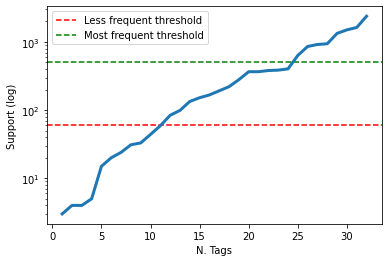

In [120]:
less_frequent_th = 60
most_frequent_th = 500
print_support_graph(test_tag_freq, less_frequent_th, most_frequent_th)

In [124]:
# F1 score on less frequent tags
tag_to_filter = {k:v for k,v in test_tag_freq.items() if v > less_frequent_th}

_, _, pred_tags, true_tags = validate(model2, val_loader, loss_function, final_vocab, train_tags, excluded_tags)
print(f'Model 2 Validation F1 on less frequent tags (< {less_frequent_th}): {macro_f1(pred_tags, true_tags, tag_to_filter):.2f}')

_, _, pred_tags, true_tags = validate(model2, test_loader, loss_function, final_vocab, train_tags, excluded_tags)
print(f'Model 2 Test F1 on less frequent tags (< {less_frequent_th}): {macro_f1(pred_tags, true_tags, tag_to_filter):.2f}')

Model 2 Validation F1 on less frequent tags (< 60): 0.82
Model 2 Test F1 on less frequent tags (< 60): 0.87


In [125]:
# F1 score on most frequent tags
tag_to_filter = {k:v for k,v in test_tag_freq.items() if v < most_frequent_th}

_, _, pred_tags, true_tags = validate(model2, val_loader, loss_function, final_vocab, train_tags, excluded_tags)
print(f'Model 2 Validation F1 on most frequent tags (> {most_frequent_th}): {macro_f1(pred_tags, true_tags, tag_to_filter):.2f}')

_, _, pred_tags, true_tags = validate(model2, test_loader, loss_function, final_vocab, train_tags, excluded_tags)
print(f'Model 2 Test F1 on most frequent tags (> {most_frequent_th}): {macro_f1(pred_tags, true_tags, tag_to_filter):.2f}')

Model 2 Validation F1 on most frequent tags (> 500): 0.83
Model 2 Test F1 on most frequent tags (> 500): 0.86


In [234]:
def evaluate_classification(true_tags, pred_tags, metric_labels, metric_tags):

    report = classification_report(true_tags, pred_tags, labels=metric_labels, target_names=metric_tags, zero_division=0, output_dict=True)
    sorted_data = dict(
        sorted(report.items(), key=lambda item: item[1]['f1-score'])
    )

    # Print the header
    print(f"{'':>12}{'precision':>10}{'recall':>10}{'f1-score':>10}{'support':>10}")

    last_rows = {}    
    for key, value in sorted_data.items():
        # I want these three at the end of the report
        if key in ['micro avg', 'macro avg', 'weighted avg']:
            last_rows[key] = value
        else:
            if value['support'] > 0:
                print(f"{key:<12}{value['precision']:>10.2f}{value['recall']:>10.2f}{value['f1-score']:>10.2f}{value['support']:>10}")
    
   
    precisions = [v['precision'] for k,v in sorted(report.items(), key=lambda item: item[1]['recall'])]
    recalls = [v['recall'] for k,v in sorted(report.items(), key=lambda item: item[1]['recall'])]

    precs_recall_curve(np.maximum.accumulate(precisions)[::-1], recalls)
    
    # print("\n")
    # for key, value in last_rows.items():
    #     print(f"{key:<12}{value['precision']:>10.2f}{value['recall']:>10.2f}{value['f1-score']:>10.2f}{value['support']:>10}")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


             precision    recall  f1-score   support
PDT               0.00      0.00      0.00         4
NNPS              0.19      0.09      0.12        44
RBS               0.50      0.33      0.40         3
RBR               0.55      0.40      0.46        15
RP                0.58      0.67      0.62        33
JJR               0.81      0.81      0.81        59
JJ                0.83      0.84      0.83       918
VBN               0.88      0.80      0.84       366
VBG               0.89      0.81      0.85       221
RB                0.86      0.86      0.86       381
VBP               0.91      0.88      0.89       134
NNP               0.91      0.90      0.91      1504
NNS               0.98      0.84      0.91       941
EX                0.83      1.00      0.91         5
NN                0.87      0.96      0.91      2383
JJS               0.97      0.90      0.93        31
VBD               0.94      0.94      0.94       634
WRB               0.96      0.92      0.94    

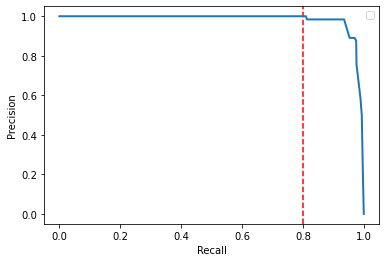

In [235]:
# Report on test set
metric_tags = [t for t in train_tags.keys() if t not in excluded_tags]
metric_labels = [v for t,v in train_tags.items() if t not in excluded_tags]

_, _, pred_tags, true_tags = validate(model2, test_loader, loss_function, final_vocab, train_tags)
evaluate_classification(true_tags, pred_tags, metric_labels, metric_tags)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


             precision    recall  f1-score   support
FW                0.00      0.00      0.00         2
UH                0.00      0.00      0.00         2
NNPS              0.28      0.10      0.15       105
PDT               0.83      0.36      0.50        14
LS                1.00      0.33      0.50         3
RBR               0.57      0.57      0.57        35
RP                0.47      0.79      0.59        43
RBS               0.69      0.69      0.69        13
JJR               0.88      0.78      0.82       165
JJS               0.90      0.79      0.84        58
VBN               0.89      0.80      0.84       737
JJ                0.84      0.86      0.85      1924
VBG               0.89      0.82      0.85       476
VBP               0.85      0.88      0.87       460
RB                0.90      0.84      0.87       951
WDT               0.94      0.85      0.89       157
NNS               0.98      0.83      0.90      2102
NN                0.85      0.95      0.90    

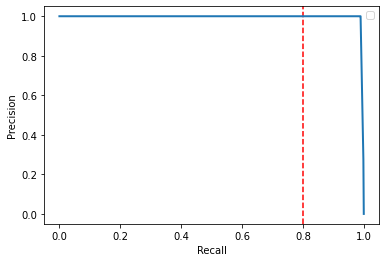

In [236]:
# Report on validation set
_, _, pred_tags, true_tags = validate(model2, val_loader, loss_function, final_vocab, train_tags)
evaluate_classification(true_tags, pred_tags, metric_labels, metric_tags)